# Objectives
- List of lists
- One-hot encoding 
- Apriori Algorithm
- Advanced filter 

## 1. Introduction to Market Basket Analysis
- market basket analysis 
  - identify products frequently purchased together 
  - construct recommendations based on these findings
- use cases 
  - Netflix-stype recommendations engine
  - improve product recommendations on an e-commerce store
  - cross-sell product in a retail setting
- Construct association
- Identify items frequently purchased together
- Association rule 
  - *antecedent* -> *consequent*: if health then cooking; if humor, travel then language, if biography then history, language
  - Finding useful rules is difficult
    - set of all possible rules is large
    - most rulse are not useful
    - must discard most rules
   - what if we restrict ourselves to simple rules
     - one antecdent to one consequent -> still challenging
   - **support and pruning**: We limit ourselves to those about the association between two items
     - a metric of performance for rules
       - support metric measures the share of transactions that contain on itemset 
       > 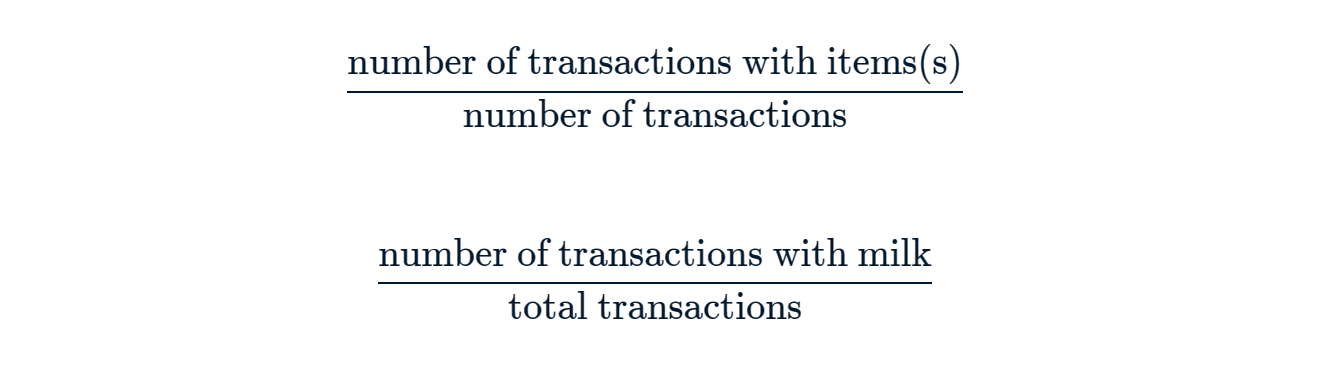
     - pruning: the use of metrics to discard rules
   - The **confidence** metric provides a more complete metric: *Support(X&Y)/Support(X)*
   - The **lift** metric evaluates the relationship between items: *Support(X&Y) / (Support(X)*Support(Y))
     - **Numerator**: proportion of transactions that contain X and Y
     - **Denominator**: proportion if X and Y assigned randomy and independently

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
path = '/QXJ/Python/Datacamp/Marketing/Basket/bookstore.csv'
books = pd.read_csv(path).reset_index()
books.columns = ['TID', 'Transaction']
books.head()

,TID,Transaction
0,0,"History,Fiction"
1,1,"History,Biography"
2,2,"Fiction,History"
3,3,"Biography,History"
4,4,"History,Poetry"


In [3]:
# split transaction strings into lists
transactions = books['Transaction'].apply(lambda t:t.split(','))
transactions = list(transactions)
print(transactions[0])

['History', 'Fiction']


In [14]:
# count the number of transactions that contain Biography and Fiction
transactions.count(['Fiction', 'Biography'])

12

In [15]:
transactions.count(['Poetry', 'Biography'])

6

In [16]:
transactions.count(['Biography', 'Poetry'])

15

**Generating rulse with itertools**

In [4]:
from itertools import permutations

#extract unique items
flattened = [item for transaction in transactions for item in transaction]
items = list(set(flattened))
items

['Fiction', 'History', 'Bookmark', 'Poetry', 'Biography']

In [5]:
# compute and print rules
rules = list(permutations(items,2))
print(rules)
# 5 items: 5 * (5-1)

[('Bookmark', 'Poetry'), ('Bookmark', 'Biography'), ('Bookmark', 'Fiction'), ('Bookmark', 'History'), ('Poetry', 'Bookmark'), ('Poetry', 'Biography'), ('Poetry', 'Fiction'), ('Poetry', 'History'), ('Biography', 'Bookmark'), ('Biography', 'Poetry'), ('Biography', 'Fiction'), ('Biography', 'History'), ('Fiction', 'Bookmark'), ('Fiction', 'Poetry'), ('Fiction', 'Biography'), ('Fiction', 'History'), ('History', 'Bookmark'), ('History', 'Poetry'), ('History', 'Biography'), ('History', 'Fiction')]


In [22]:
print(len(rules))

20


**Support and pruning**

In [28]:
transactions[:5]

[['History', 'Fiction'],
 ['History', 'Biography'],
 ['Fiction', 'History'],
 ['Biography', 'History'],
 ['History', 'Poetry']]

In [30]:
print(type(transactions))

<class 'list'>


In [6]:
from mlxtend.preprocessing import TransactionEncoder

# instantiate transaction encoder
encoder = TransactionEncoder().fit(transactions)
# one-hot encode itemsets by applying fit and transform
onehot= encoder.transform(transactions)

# convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot.head()

,Biography,Bookmark,Fiction,History,Poetry
0,False,False,True,True,False
1,True,False,False,True,False
2,False,False,True,True,False
3,True,False,False,True,False
4,False,False,False,True,True


In [31]:
print(onehot.mean())

Biography    0.666667
Bookmark     0.010101
Fiction      0.454545
History      0.474747
Poetry       0.383838
dtype: float64


In [33]:
# computing support for mulitple items
# define itemset that contains fiction and poetry
onehot['Fiction + Poetry'] = np.logical_and(onehot['Fiction'],
                                           onehot['Poetry'])
print(onehot.mean())

Biography           0.666667
Bookmark            0.010101
Fiction             0.454545
History             0.474747
Poetry              0.383838
Fiction + Poetry    0.070707
dtype: float64


## 2. Association Rules
- The **confidence** metric provides a more complete metric: *Support(X&Y)/Support(X)*
  - The probability that we will purchase Y, given that we have purchased X
- The **lift** metric evaluates the relationship between items: *Support(X&Y) / (Support(X)*Support(Y))
   - **Numerator**: proportion of transactions that contain X and Y
   - **Denominator**: proportion if X and Y assigned randomy and independently
   - The probabilty of buying X and Y to buying individual X and Y
- The **leverage** metric: *leverage(X->Y) = support(X&Y) - support(X)support(Y)
  - easy to intepret and **lies in -1 and +1 range**
    - **lift** ranges from 0 to infinity
- The **conviction** is more complicated and less intuitive than leverage: *conviction(X->Y) = support(X)support(y-bar)/support(X&Y-bar)*
- Association and dissociation
  - **Zhang's** metric: takes value between -1(perfect dissociation) and +1(perfect association)
    > 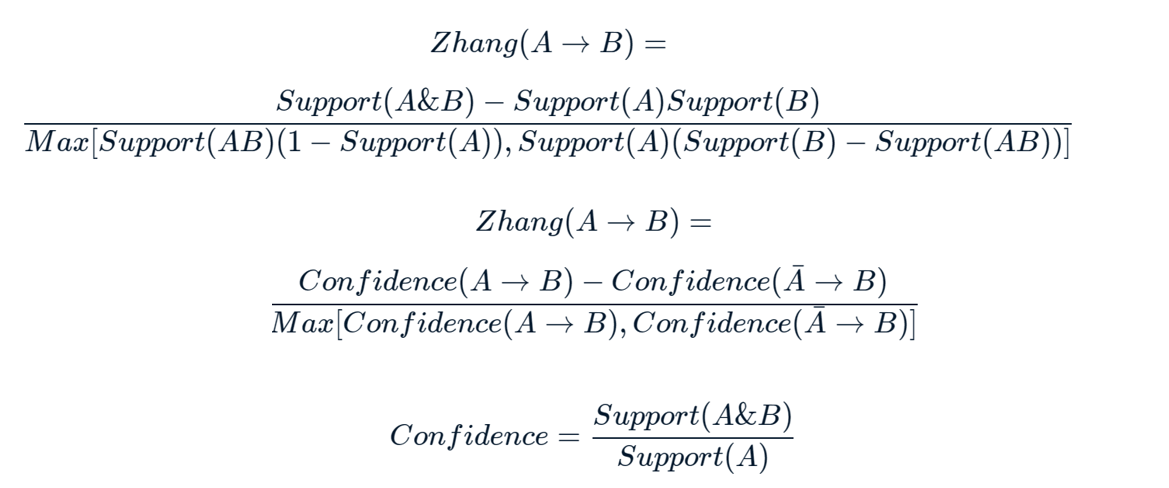
    - confidence indicates the association 
- Advanced rules: overview of market basket analysis
  - step I: generate large set of rules
    - Number of rules grows exponentially in number of items
      - Most rules are not useful -> chapter 1
    - Must apply initial round of filtering by using **support**
      - convered in chapter 3 using apriori algorithm
  - step II: filter(or prune) rules using multiple metrics to
  - step III: apply intuition and common sense

In [8]:
onehot.head()

,Biography,Bookmark,Fiction,History,Poetry
0,False,False,True,True,False
1,True,False,False,True,False
2,False,False,True,True,False
3,True,False,False,True,False
4,False,False,False,True,True


In [11]:
# compurting support
supportBH = np.logical_and(onehot['Biography'], onehot['History']).mean()
supportB = onehot['Biography'].mean()
supportH = onehot['History'].mean()
print(supportBH, supportB, supportH)

0.21212121212121213 0.6666666666666666 0.47474747474747475


In [13]:
# comput and print confidence and lift
confidence = supportBH / supportH
lift = supportBH / (supportB * supportH)
print(supportH, confidence, lift)

0.47474747474747475 0.4468085106382979 0.6702127659574468


**Interpret**: *if the readers read biograghy highly, that lowers the probability that he will also read histroy highly from 0.475 to 0.447. The lift is less than 1, which means the same.*

**Leverage and conviction**

In [15]:
# computing leverage
leverage = supportBH - supportB * supportH
print(leverage)
# which is positive and equivalent to life being greater than 1

-0.10437710437710437


In [16]:
# compute support for not history
supportnH = 1.0 - supportH

# compute support for Bio and not history
supportBnH = supportB - supportH

# compute convictin
conviction = supportB * supportnH / supportBnH
print(conviction)

1.8245614035087725


*Conviction is greater than 1 which provides further evidence for the rule "if  Bio than History".*

In [46]:
def conviction(antecedent, consequent):
    # Compute support for antecedent AND consequent
    supportAC = np.logical_and(antecedent, consequent).mean()

    # Compute support for antecedent
    supportA = antecedent.mean()

    # Compute support for NOT consequent
    supportnC = 1.0 - consequent.mean()

    # Compute support for antecedent and NOT consequent
    supportAnC = supportA - supportAC

    # Return conviction
    return supportA * supportnC / supportAnC

**Association and dissociation**

In [17]:
# compute the numerator
num = supportBH - supportB * supportH

# compute the denominator
denom = max(supportBH*(1-supportB), supportB*(supportH-supportBH))

# compute Zhang's metric
zhang = num/denom
print(zhang)

-0.5961538461538461


In [45]:
# Define a function to compute Zhang's metric
def zhang(antecedent, consequent):
    # Compute the support of each book
    supportA = antecedent.mean()
    supportC = consequent.mean()

    # Compute the support of both books
    supportAC = np.logical_and(antecedent, consequent).mean()

    # Complete the expressions for the numerator and denominator
    numerator = supportAC - supportA*supportC
    denominator = max(supportAC*(1-supportA), supportA*(supportC-supportAC))

    # Return Zhang's metric
    return numerator / denominator

In [ ]:
# Define an empty list for Zhang's metric
zhangs_metric = []

# Loop over lists in itemsets
for itemset in itemsets:
    # Extract the antecedent and consequent columns
    antecedent = books[itemset[0]]
    consequent = books[itemset[1]]
    
    # Complete Zhang's metric and append it to the list
    zhangs_metric.append(zhang(antecedent, consequent))
    
# Print results
rules['zhang'] = zhangs_metric
print(rules)

**Advanced rules**

In [42]:
antecedents = ['Potter', 'Potter', 'Twilight', 'Hunger', 'Mochingbird']
consequents = ['Hungry', 'Hunger', 'Hunger', 'Twilight', 'Hunger']
antecedent_support = [0.48, 0.32, 0.26, 0.32, 0.48]
consequents_support = [0.12, 0.02, 0.04, 0.09, 0.10]
lift = [0.92, 1.92, 1.04, 1.53, 0.85]
confidence = [0.26, 0.26, 1.35, 0.28, 1.20]
conviction = [0.92, 0.92, 1.04, 1.03, 0.85]

rules =  pd.DataFrame({'antecedents': antecedents,
                      'consequents': consequents,
                      'antecedents_suppport' : antecedent_support,
                      'consequents_support':consequents_support,
                       'lift': lift,
                      'confidence': confidence,
                      'conviction':conviction} )
rules

,antecedents,consequents,antecedents_suppport,consequents_support,lift,confidence,conviction
0,Potter,Hungry,0.48,0.12,0.92,0.26,0.92
1,Potter,Hunger,0.32,0.02,1.92,0.26,0.92
2,Twilight,Hunger,0.26,0.04,1.04,1.35,1.04
3,Hunger,Twilight,0.32,0.09,1.53,0.28,1.03
4,Mochingbird,Hunger,0.48,0.10,0.85,1.20,0.85


In [43]:
# 1. select subset of rules with low consequent support
rules = rules[rules['consequents_support'] < 0.05]
print(len(rules))

2


In [44]:
#2. select subsets rules with lift > 1.5
rules = rules[rules['lift'] > 1.5]
print(len(rules))

1


## 3. Aggregation and Pruning
- Pruning and aggregation 
  - Pruning: remove items and rules with low support or poor performance along some other measures
  - aggregation: group items together into category
    - items -> categories
    - compute metrics
    - identify rules
- The Apriori algorithm
  - remove itemsets withouteven evaluating it
    - count set maximum k value
      > 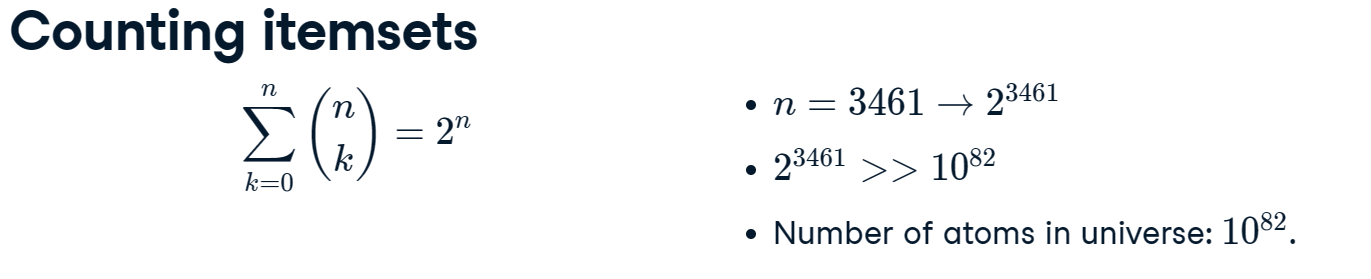
    - apriori algorithm: sensible rule for pruning
  - the Apriori principle
    > 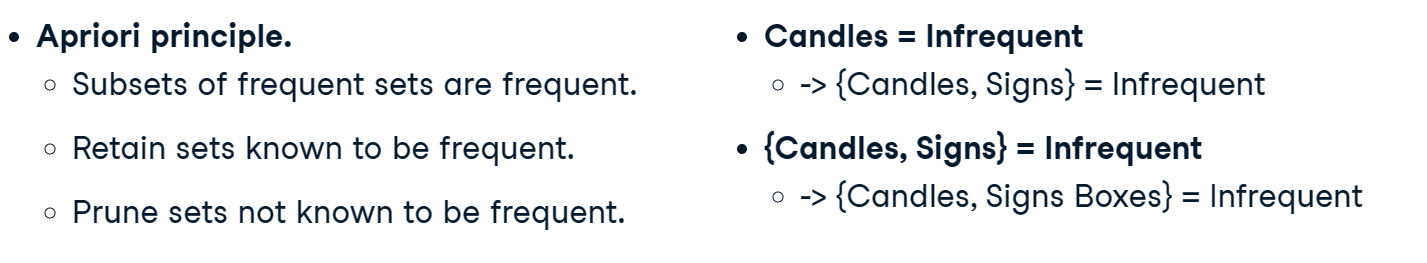
    - does not indicate association
  - Computing rules from Apriori results
    - difficulte to enumerate for high n and k
    - could undo itemset pruning by Apriori
  - reducing number of association rules
    - **mlxtend** module offers means of pruning assciation rules
    - **association_rules()** takes frequent items, metric; and threshold
  - Advanced apriori results pruning

In [34]:
path = '/QXJ/Python/Datacamp/Marketing/Basket/online_retail.csv'
gifts = pd.read_csv(path)
gifts.head()

,InvoiceNo,StockCode,Description
0,562583,35637A,IVORY STRING CURTAIN WITH POLE
1,562583,35638A,PINK AND BLACK STRING CURTAIN
2,562583,84927F,PSYCHEDELIC TILE HOOK
3,562583,22425,ENAMEL COLANDER CREAM
4,562583,16008,SMALL FOLDING SCISSOR(POINTED EDGE)


In [9]:
# number of transactions
print(len(gift['InvoiceNo'].unique()))

9709


In [49]:
# number of items
print(len(gift['Description'].unique()))

3461


In [20]:
descriptions = gift['Description'].to_list()
descriptions = list(set(descriptions))
len(descriptions)

3461

In [21]:
descriptions[:10]

[nan,
 'DECORATION WOBBLY CHICKEN',
 'CERAMIC CHERRY CAKE MONEY BANK',
 "can't find",
 'COSY SLIPPER SHOES SMALL  RED ',
 'DOORMAT VINTAGE LEAF',
 'UNION JACK FLAG LUGGAGE TAG',
 'PICTURE DOMINOES',
 '3 HOOK PHOTO SHELF ANTIQUE WHITE',
 'NECKLACE+BRACELET PINK BUTTERFLY']

In [24]:
new_list = [item for item in descriptions if not(pd.isnull(item)) == True]
print(new_list[:5])

['DECORATION WOBBLY CHICKEN', 'CERAMIC CHERRY CAKE MONEY BANK', "can't find", 'COSY SLIPPER SHOES SMALL  RED ', 'DOORMAT VINTAGE LEAF']


In [ ]:
# select the column names for bags and boxes 
bag_headers = [i for i in onehot.columns if i.lower().find('bag') >= 0]
box_headers = [i for i in onehot.columns if i.lower().find('box') >= 0]

In [ ]:
# identify column headers
bags = onehot[bag_headers]
boxes = onehot[box_headers]

In [ ]:
# sum over columns 
bags = (bags.sum(axis = 1) > 0.0).values
boxes = (boxes.sum(axis = 1) > 0.0).values 

In [ ]:
# add result to DataFrame
aggregated = pd.DataFrame(np.vstack([bags, boxes]).T, column = ['bags', 'boxes'])
aggregated.head()
                        

In [ ]:
# compute support
print(aggregated.mean())


In [39]:
path = '/QXJ/Python/Datacamp/Marketing/Basket/movielens_movies.csv'
movie = pd.read_csv(path)
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [40]:
# split genres column and make a list
genres = move['genres'].apply(lambda g:g.split('|'))
genres = list(genres)
genres[:10]

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Adventure', 'Children', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy'],
 ['Action', 'Crime', 'Thriller'],
 ['Comedy', 'Romance'],
 ['Adventure', 'Children'],
 ['Action'],
 ['Action', 'Adventure', 'Thriller']]

In [41]:
# flattern a list of non-duplicates
from itertools import permutations

#extract unique items
flattened = [movie for genre in genres for movie in genre]
genre = list(set(flattened))
genre

['(no genres listed)',
 'Animation',
 'Thriller',
 'Documentary',
 'Drama',
 'Western',
 'War',
 'IMAX',
 'Adventure',
 'Comedy',
 'Children',
 'Crime',
 'Film-Noir',
 'Fantasy',
 'Horror',
 'Musical',
 'Action',
 'Sci-Fi',
 'Mystery',
 'Romance']

In [42]:
# onhot encoder
from mlxtend.preprocessing import TransactionEncoder

# instantiate transaction encoder
encoder = TransactionEncoder().fit(genres)
# one-hot encode itemsets by applying fit and transform
onehot= encoder.transform(genres)

# convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_).drop('(no genres listed)', axis = 1)
onehot.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


**Apriori implementation**

In [46]:
from mlxtend.frequent_patterns import apriori

In [17]:
# compute frequent itemsets
frequent_itemsets = apriori(onehot, min_support = 0.0005,
                           max_len = 4, use_colnames = True)

print(len(frequent_itemsets))

531


In [18]:
frequent_itemsets

,support,itemsets
0,0.129042,(Action)
1,0.085380,(Adventure)
2,0.037649,(Animation)
3,0.041755,(Children)
4,0.306987,(Comedy)
...,...,...
526,0.000807,"(Sci-Fi, Horror, Thriller, Drama)"
527,0.001210,"(Thriller, Romance, Mystery, Drama)"
528,0.001100,"(Sci-Fi, Thriller, Mystery, Drama)"
529,0.000623,"(Horror, Thriller, Fantasy, Mystery)"


In [20]:
# import apriori algorithm
from mlxtend.frequent_patterns import apriori, association_rules

# apply apriori algorithm
frequent_itemsets = apriori(onehot,
                           use_colnames = True, 
                           min_support = 0.0001)

In [22]:
frequent_itemsets

,support,itemsets
0,0.129042,(Action)
1,0.085380,(Adventure)
2,0.037649,(Animation)
3,0.041755,(Children)
4,0.306987,(Comedy)
...,...,...
1428,0.000147,"(Musical, Animation, Comedy, Children, Fantasy..."
1429,0.000110,"(Animation, Crime, Comedy, Thriller, Romance, ..."
1430,0.000110,"(Crime, Comedy, Mystery, Thriller, Romance, Dr..."
1431,0.000110,"(Sci-Fi, Comedy, Thriller, Mystery, Fantasy, D..."


In [23]:
# compute association rules
rules = association_rules(frequent_itemsets, 
                         metric = 'support',
                         min_threshold = 0.0)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Action),(Adventure),0.129042,0.085380,0.035633,0.276136,3.234198,0.024616,1.263525
1,(Adventure),(Action),0.085380,0.129042,0.035633,0.417347,3.234198,0.024616,1.494813
2,(Action),(Animation),0.129042,0.037649,0.007259,0.056250,1.494048,0.002400,1.019709
3,(Animation),(Action),0.037649,0.129042,0.007259,0.192795,1.494048,0.002400,1.078980
4,(Action),(Children),0.129042,0.041755,0.003739,0.028977,0.693979,-0.001649,0.986841
...,...,...,...,...,...,...,...,...,...
18447,(Crime),"(Action, Animation, Comedy, Thriller, Romance,...",0.107743,0.000110,0.000110,0.001021,9.281388,0.000098,1.000912
18448,(Comedy),"(Action, Animation, Crime, Thriller, Romance, ...",0.306987,0.000110,0.000110,0.000358,3.257464,0.000076,1.000248
18449,(Thriller),"(Action, Animation, Comedy, Crime, Romance, Dr...",0.153164,0.000110,0.000110,0.000718,6.528961,0.000093,1.000609
18450,(Romance),"(Action, Animation, Comedy, Crime, Thriller, D...",0.151294,0.000110,0.000110,0.000727,6.609644,0.000093,1.000617


In [24]:
frequent_itemsets

,support,itemsets
0,0.129042,(Action)
1,0.085380,(Adventure)
2,0.037649,(Animation)
3,0.041755,(Children)
4,0.306987,(Comedy)
...,...,...
1428,0.000147,"(Musical, Animation, Comedy, Children, Fantasy..."
1429,0.000110,"(Animation, Crime, Comedy, Thriller, Romance, ..."
1430,0.000110,"(Crime, Comedy, Mystery, Thriller, Romance, Dr..."
1431,0.000110,"(Sci-Fi, Comedy, Thriller, Mystery, Fantasy, D..."


**the importance of pruning**

In [26]:
# compurte association rules
rules = association_rules(frequent_itemsets,
                         metric = 'support',
                         min_threshold = 0.01)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Action),(Adventure),0.129042,0.085380,0.035633,0.276136,3.234198,0.024616,1.263525
1,(Adventure),(Action),0.085380,0.129042,0.035633,0.417347,3.234198,0.024616,1.494813
2,(Action),(Comedy),0.129042,0.306987,0.026358,0.204261,0.665374,-0.013256,0.870905
3,(Comedy),(Action),0.306987,0.129042,0.026358,0.085861,0.665374,-0.013256,0.952764
4,(Action),(Crime),0.129042,0.107743,0.028118,0.217898,2.022393,0.014215,1.140845
...,...,...,...,...,...,...,...,...,...
121,"(Thriller, Drama)",(Mystery),0.068480,0.055503,0.012684,0.185225,3.337228,0.008883,1.159212
122,"(Mystery, Drama)",(Thriller),0.026432,0.153164,0.012684,0.479889,3.133177,0.008636,1.628184
123,(Thriller),"(Mystery, Drama)",0.153164,0.026432,0.012684,0.082815,3.133177,0.008636,1.061474
124,(Mystery),"(Thriller, Drama)",0.055503,0.068480,0.012684,0.228534,3.337228,0.008883,1.207467


In [27]:
# expore the set of rules
rules.columns

Index(['antecedents', 'consequents', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift', 'leverage',
       'conviction'],
      dtype='object')

In [29]:
rules[['antecedents', 'consequents']]

,antecedents,consequents
0,(Action),(Adventure)
1,(Adventure),(Action)
2,(Action),(Comedy)
3,(Comedy),(Action)
4,(Action),(Crime)
...,...,...
121,"(Thriller, Drama)",(Mystery)
122,"(Mystery, Drama)",(Thriller)
123,(Thriller),"(Mystery, Drama)"
124,(Mystery),"(Thriller, Drama)"


**Pruning with other metrics**

In [32]:
# compute association rules
rules = association_rules(frequent_itemsets,
                         metric = 'antecedent support',
                         min_threshold = 0.02)
len(rules)

7133

**Advanced Apriori results pruning**

In [33]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [ ]:
itemsets = np.load('itemset.npy')

In [ ]:
# one-hot encode data 
encoder = TransactionEncoder()
onehot = encoder.fit(itemsets).transform(itemsets)
onehot= pd.DataFrame(onehot, columns = encoder.columns_)

In [ ]:
# apply apriori algorithm and print
frequent_itemsets = apriori(onehot,
                           use_colnames = True, 
                           min_support = 0.001)
print(len(data.columns))
print(len(frequent_itemsets))

In [ ]:
rules = association_rules(frequent_itemsets)

*to cross-promote the herb market thyme item*

In [ ]:
targeted_rules = rules[rules['consequents'] == {'herb marker thyme'}].copy()

filtered_rules = targeted_rules[(targeted_rules['antecedent supoort'] > 0.01) &
                               (targeted_rules['supoort'] > 0.009) &
                               (targeted_rules['confidence'] > 0.85) &
                               (targeted_rules['lift'] > 1)]

print(filtered_rules['antecedents'])

*The store we are advising is re-locating to a hourseshoe-shaped building -> how to arrange the store and wants our input*
- the objective should be to keep disassociated items apart -> Zhang's metric

**aggregation and dissociation**

In [ ]:
# load aggregated data
aggregated = pd.read_csv('datasets/online_retail_aggregated.csv')

# compute frequent itemsets
onehot = encoder.fit(aggregated).transform(aggregated)
data = pd.DataFrame(onehot, columns = encoder.columns_)
frequent_itemsets = apriori(data, use_colcolumns = True)

# compute standard metrics
rules = association_rules(frequent_itemsets)

In [ ]:
# compute Zhang's rule
rules['zhang'] = zhangs_rule(rules)

In [ ]:
# print rules that indicate dissociation
print(rules[rules['zhang'] < 0][['antecedents', 'consequents']])

## 4.Visualizing Rules
- heatmap
- scatterplot
- parallel coordinates plot

### heatmap
- Generate the rules
  - Use apriori algorithm and association rules
- Convert antecedents and consequents into strings
  - stored as frozen sets by default in mlxtend
- Convert rules into matrix format 
  - suitable for use in heatmaps

In [35]:
gifts.head(3)

,InvoiceNo,StockCode,Description
0,562583,35637A,IVORY STRING CURTAIN WITH POLE
1,562583,35638A,PINK AND BLACK STRING CURTAIN
2,562583,84927F,PSYCHEDELIC TILE HOOK


In [ ]:
# recover unique invoice IDs
invoice_no = gifts['InvoiceNo'].unique()

# create library of highly rated movies for each invoice
libraries = [list(gifts[gifts['InvoiceNo'] == u].Description) for u in invoice_no]

print(library[0])

In [65]:
# apply the apriori algorithm
frequent_itemsets = apriori(onehot,
                           min_support = 0.0005,
                           use_colnames = True)

# recover the association rules 
rules = association_rules(frequent_itemsets)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Sci-Fi, IMAX)",(Action),0.002310,0.129042,0.001906,0.825397,6.396356,0.001608,4.988216
1,"(Thriller, IMAX)",(Action),0.001320,0.129042,0.001063,0.805556,6.242598,0.000893,4.479214
2,"(War, Romance)",(Drama),0.006965,0.489185,0.006012,0.863158,1.764480,0.002605,3.732876
3,"(Sci-Fi, Adventure, IMAX)",(Action),0.001100,0.129042,0.000990,0.900000,6.974489,0.000848,8.709583
4,"(Sci-Fi, Thriller, IMAX)",(Action),0.000697,0.129042,0.000587,0.842105,6.525837,0.000497,5.516069
5,"(Adventure, Animation, IMAX)",(Children),0.000733,0.041755,0.000587,0.800000,19.159263,0.000556,4.791224
6,"(Musical, Adventure, Animation)",(Children),0.001210,0.041755,0.001026,0.848485,20.320430,0.000976,6.324415
7,"(Animation, Comedy, IMAX)",(Children),0.000660,0.041755,0.000587,0.888889,21.288069,0.000559,8.624203
8,"(Children, Comedy, IMAX)",(Animation),0.000660,0.037649,0.000587,0.888889,23.609651,0.000562,8.661156
9,"(Mystery, Action, Crime, Drama)",(Thriller),0.000697,0.153164,0.000660,0.947368,6.185332,0.000553,16.089889


**generating a heatmap**

In [66]:
# convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a:','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a:','.join(list(a)))

In [67]:
print(rules[['antecedents','consequents']])

                   antecedents consequents
0                  Sci-Fi,IMAX      Action
1                Thriller,IMAX      Action
2                  War,Romance       Drama
3        Sci-Fi,Adventure,IMAX      Action
4         Sci-Fi,Thriller,IMAX      Action
5     Adventure,Animation,IMAX    Children
6  Musical,Adventure,Animation    Children
7        Animation,Comedy,IMAX    Children
8         Children,Comedy,IMAX   Animation
9   Mystery,Action,Crime,Drama    Thriller


In [68]:
# transform into matrix
support_table = rules.pivot_table(index = 'consequents',
                           columns = 'antecedents',
                           values = 'support')
support_table

antecedents,"Adventure,Animation,IMAX","Animation,Comedy,IMAX","Children,Comedy,IMAX","Musical,Adventure,Animation","Mystery,Action,Crime,Drama","Sci-Fi,Adventure,IMAX","Sci-Fi,IMAX","Sci-Fi,Thriller,IMAX","Thriller,IMAX","War,Romance"
consequents,,,,,,,,,,
Action,NaN,NaN,NaN,NaN,NaN,0.00099,0.001906,0.000587,0.001063,NaN
Animation,NaN,NaN,0.000587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Children,0.000587,0.000587,NaN,0.001026,NaN,NaN,NaN,NaN,NaN,NaN
Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006012
Thriller,NaN,NaN,NaN,NaN,0.00066,NaN,NaN,NaN,NaN,NaN


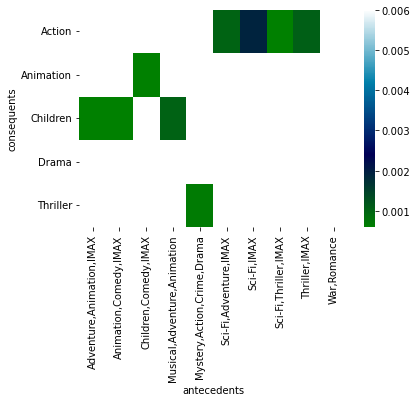

In [70]:
sns.heatmap(support_table,
           cmap = 'ocean')
plt.show()

### Scatterplot
- A scatterplot displays pairs of values
  - antecedent and consequent support
  - confidence and lift
- No model is assumed
  - no trend line or curve needed
- Can provide starting point for pruning
  - identify patterns in data and rules
- What can we learn from scatterplot
  - identify natural thresholds in data
    - not possible with heatmaps or other visualizations
  - visualize entire dataset
    - not limited to small number of rules
   - use findings to prune
     - use natural thresholds and patterns to prune

In [74]:
# apply the apriori algorithm
frequent_itemsets = apriori(onehot,
                           min_support = 0.0001,
                           use_colnames = True,
                           max_len = 2)

# recover the association rules 
rules = association_rules(frequent_itemsets, 
                          metric='support',
                         min_threshold = 0.0)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Action),(Adventure),0.129042,0.085380,0.035633,0.276136,3.234198,0.024616,1.263525
1,(Adventure),(Action),0.085380,0.129042,0.035633,0.417347,3.234198,0.024616,1.494813
2,(Action),(Animation),0.129042,0.037649,0.007259,0.056250,1.494048,0.002400,1.019709
3,(Animation),(Action),0.037649,0.129042,0.007259,0.192795,1.494048,0.002400,1.078980
4,(Action),(Children),0.129042,0.041755,0.003739,0.028977,0.693979,-0.001649,0.986841
...,...,...,...,...,...,...,...,...,...
323,(Thriller),(War),0.153164,0.043772,0.003666,0.023935,0.546814,-0.003038,0.979677
324,(Western),(Thriller),0.024782,0.153164,0.000990,0.039941,0.260772,-0.002806,0.882067
325,(Thriller),(Western),0.153164,0.024782,0.000990,0.006462,0.260772,-0.002806,0.981561
326,(Western),(War),0.024782,0.043772,0.000990,0.039941,0.912484,-0.000095,0.996010


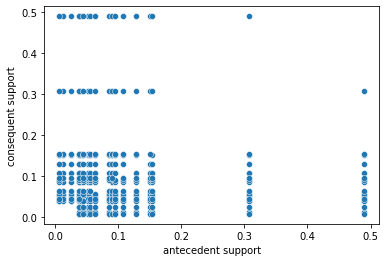

In [75]:
sns.scatterplot(x = 'antecedent support', 
                y = 'consequent support', 
                data = rules)
plt.show()

- none of them exceeds 0.5
- the values clustering below 0.18
- high lift is associated with low antecedent and consequent support -> which suggests the high lift might is generated by small users, not informative 
- this plot convince use to treat very high values of lift with skeptism

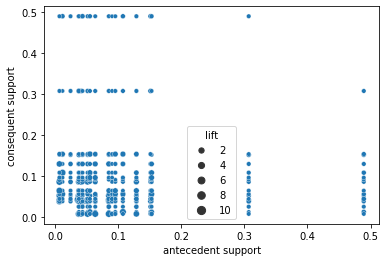

In [76]:
sns.scatterplot(x = 'antecedent support', 
                y = 'consequent support',
                size = 'lift',
                data = rules)
plt.show()

### Parallel coordinates plot
- Parallel coordinates vs. heatmap
  - do not need intensity information
  - only want to know whether rule exists
  - want to reduce visual clutter
- Parallel coordinates vs scatterplot
  - want individual rule information 
  - not interested in multiple-metrics
  - only want to examine final rules

In [82]:
# apply the apriori algorithm
frequent_itemsets = apriori(onehot,
                           min_support = 0.05,
                           use_colnames = True,
                           max_len = 2)

# recover the association rules 
rules = association_rules(frequent_itemsets, 
                          metric='support',
                         min_threshold = 0.0)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Comedy),(Drama),0.306987,0.489185,0.093335,0.304036,0.621515,-0.056838,0.733967
1,(Drama),(Comedy),0.489185,0.306987,0.093335,0.190797,0.621515,-0.056838,0.856414
2,(Romance),(Comedy),0.151294,0.306987,0.069470,0.459171,1.495734,0.023025,1.281390
3,(Comedy),(Romance),0.306987,0.151294,0.069470,0.226296,1.495734,0.023025,1.096938
4,(Crime),(Drama),0.107743,0.489185,0.062761,0.582511,1.190778,0.010055,1.223540
5,(Drama),(Crime),0.489185,0.107743,0.062761,0.128297,1.190778,0.010055,1.023580
6,(Romance),(Drama),0.151294,0.489185,0.094325,0.623455,1.274476,0.020314,1.356584
7,(Drama),(Romance),0.489185,0.151294,0.094325,0.192821,1.274476,0.020314,1.051447
8,(Thriller),(Drama),0.153164,0.489185,0.068480,0.447104,0.913976,-0.006445,0.923889
9,(Drama),(Thriller),0.489185,0.153164,0.068480,0.139988,0.913976,-0.006445,0.984680


In [85]:
# concert rules to coorinates
rules['antecedent'] = rules['antecedents']\
.apply(lambda antecedent: list(antecedent)[0])
rules['consequent'] = rules['consequents']\
.apply(lambda consequent: list(consequent)[0])
rules['rule'] = rules.index
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent,consequent,rule
0,(Comedy),(Drama),0.306987,0.489185,0.093335,0.304036,0.621515,-0.056838,0.733967,Comedy,Drama,0
1,(Drama),(Comedy),0.489185,0.306987,0.093335,0.190797,0.621515,-0.056838,0.856414,Drama,Comedy,1
2,(Romance),(Comedy),0.151294,0.306987,0.069470,0.459171,1.495734,0.023025,1.281390,Romance,Comedy,2
3,(Comedy),(Romance),0.306987,0.151294,0.069470,0.226296,1.495734,0.023025,1.096938,Comedy,Romance,3
4,(Crime),(Drama),0.107743,0.489185,0.062761,0.582511,1.190778,0.010055,1.223540,Crime,Drama,4
5,(Drama),(Crime),0.489185,0.107743,0.062761,0.128297,1.190778,0.010055,1.023580,Drama,Crime,5
6,(Romance),(Drama),0.151294,0.489185,0.094325,0.623455,1.274476,0.020314,1.356584,Romance,Drama,6
7,(Drama),(Romance),0.489185,0.151294,0.094325,0.192821,1.274476,0.020314,1.051447,Drama,Romance,7
8,(Thriller),(Drama),0.153164,0.489185,0.068480,0.447104,0.913976,-0.006445,0.923889,Thriller,Drama,8
9,(Drama),(Thriller),0.489185,0.153164,0.068480,0.139988,0.913976,-0.006445,0.984680,Drama,Thriller,9


In [86]:
# define coordinates and label
coords = rules[['antecedent', 'consequent', 'rule']]

print(coords.head(1))

  antecedent consequent  rule
0     Comedy      Drama     0


<AxesSubplot:>

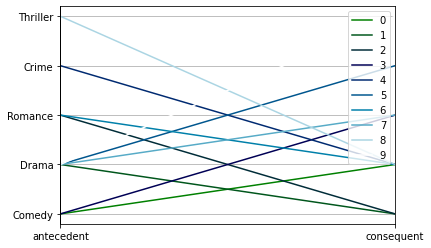

In [87]:
# generating a parallel coordination
from pandas.plotting import parallel_coordinates

parallel_coordinates(coords, 'rule', colormap= 'ocean')